In [1]:
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

is_cuda = torch.cuda.is_available()
device = 'cuda' if is_cuda else 'cpu'
if not is_cuda:
    print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")
    
torch.set_printoptions(precision=3, sci_mode=False)
np.set_printoptions(suppress=True)

In [2]:
from lib.Baseline import ConditionalGenerator, Critic
from lib.Utilities import plot_baseline as plot, get_n_params
from lib.Training_wgan import train_wgan

In [3]:
data = torch.load('../data/data.pt')

for dataset in data:
    data[dataset] = data[dataset].float()

In [4]:
C = Critic(input_size = [2,2], hidden_size = [32,32], num_layers = [4,4], sep=data['X_train'].shape[1]).float().to(device)
G = ConditionalGenerator(input_size = 2, output_size = 2, hidden_size = 64, num_layers = 2, noise_size = 5, 
                         translation = True).to('cuda')

We will scale the parameters of the generator to have the right size. This is done by trial and error, and will help training.

Total number of parameters of the Generator:     102274
Total number of parameters of the Critic:      59969


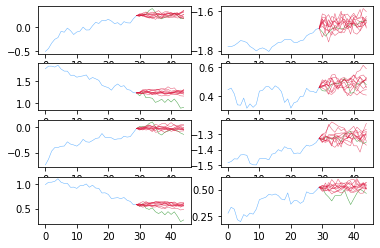

In [5]:
C = Critic(input_size = [2,2], hidden_size = [32,32], num_layers = [4, 4], sep=data['X_train'].shape[1]).float().to(device)
G = ConditionalGenerator(input_size = 2, output_size = 2, hidden_size = 64, num_layers = 2, noise_size = 5, 
                         translation = True).to('cuda')

print(f"Total number of parameters of the Generator: {get_n_params(G):10}")
print(f"Total number of parameters of the Critic: {get_n_params(C):10}")

init_mult1 = 1
init_mult2 = 10
init_mult3 = 0.2
init_multC = 4
with torch.no_grad():
    for param in G.encoder.parameters():
        param *= init_mult1
        
    for param in G.cgenerator.parameters():
        param *= init_mult2
        
    for param in G.out.parameters():
        param *= init_mult3
        
    for param in C.parameters():
        param *= init_multC
        
plot(G=G, X_data=data['X_train'], Y_data=data['Y_train'], nsamples_fs=10, output_size = 2, device='cuda')

In [6]:
G_optimizer = torch.optim.RMSprop(G.parameters(), lr=1e-3)
C_optimizer = torch.optim.RMSprop(C.parameters(), lr=1e-3)

q = data['Y_train'].shape[1]-1

In [7]:
hp = {'nsteps_pretrain': 1, 'gp_lambda': 10, 'steps_per_print': 250, 'nsamples_fs': 10, 'steps':10,
     'nsteps_disc': 10, 'batch_size': 1024}

In [8]:
train_dataset = TensorDataset(data['X_train'][:, :, 1:], data['Y_train'][:, :, 1:])
train_dataloader = DataLoader(train_dataset, hp['batch_size'], shuffle=True)


val_dataset = TensorDataset(data['X_val'][:, :, 1:], data['Y_val'][:, :, 1:])
val_dataloader = DataLoader(val_dataset, hp['batch_size'], shuffle=True)

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Step:   0 Loss: -0.0074 G. score: -0.7773 R. score: -0.7699 GP: 4.3789


  0%|          | 0/10 [00:00<?, ?it/s]

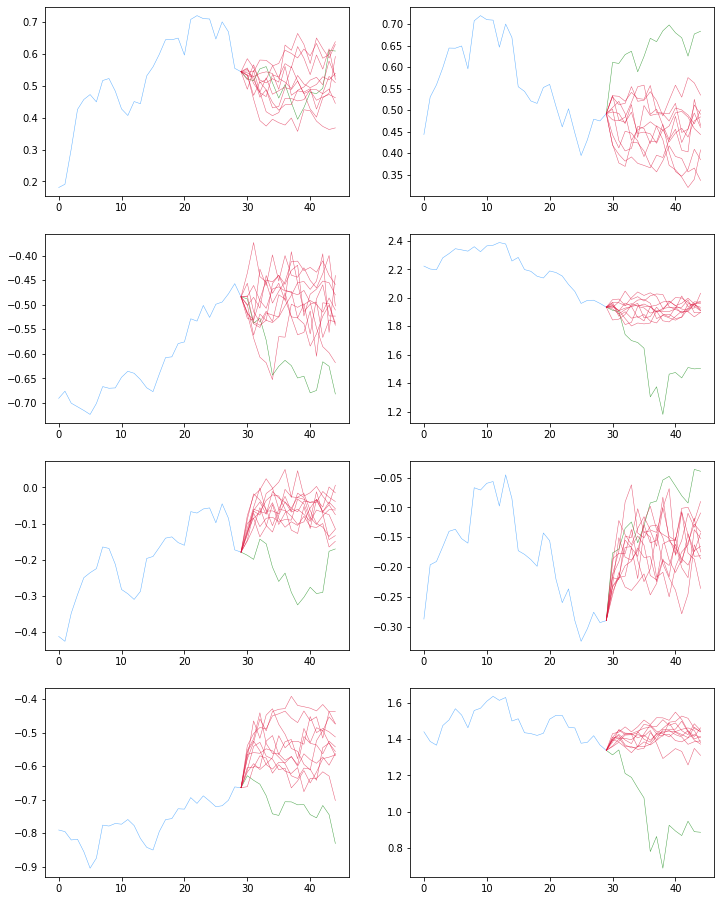

 10%|█         | 1/10 [00:06<00:55,  6.21s/it]

Step:   0 Loss: 0.0127 G. score: -0.2309 R. score: -0.2436 GP: 0.3284


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]

Total time (in hours): 0.0159 Number of steps:     9
Maximum memory allocated (in MB): 1788.1160 Total number of parameters G:     102274 Total number of parameters C:      59969


In [9]:
G, C, G_optimizer, C_optimizer = train_wgan(C, G, train_dataloader, hp, data['X_train'], data['Y_train'], 
                                            G_optimizer, C_optimizer, output_size = 2, max_time=2)

We load the pre-trained model.

In [10]:
save_model=False
if save_model:
    torch.save(G.state_dict(), 'G.pt')
    
load_model = True
if load_model:
    G.load_state_dict(torch.load('G.pt'))

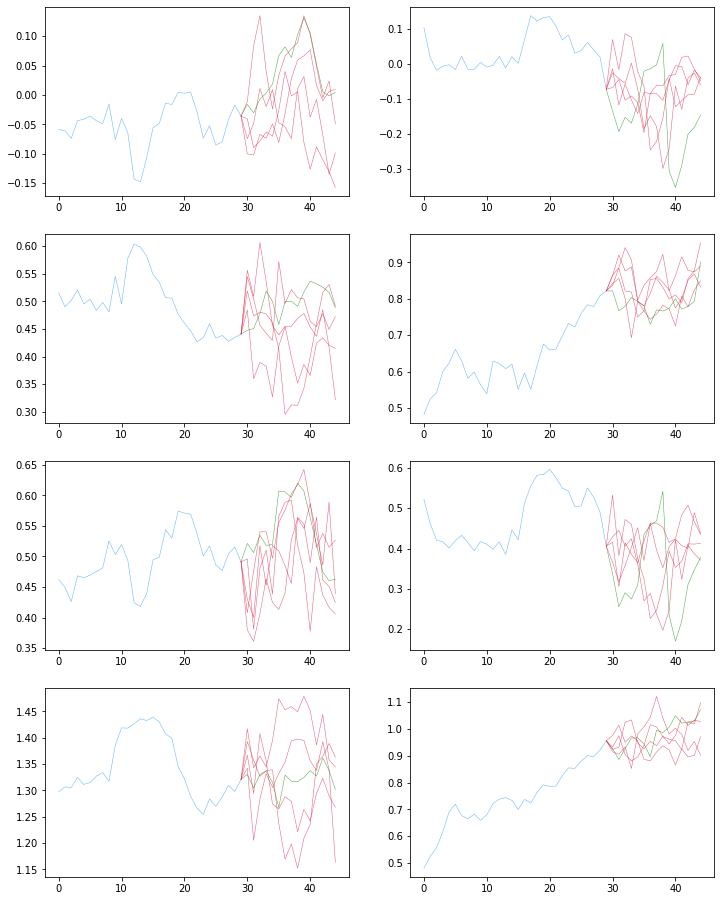

In [11]:
plot(G=G.to(device), X_data=data['X_test'], Y_data=data['Y_test'], nsamples_fs=4, output_size = 2, device='cuda')

## Metrics

Next we evaluate the model according to the different metrics described in the memory.

### Classification error

First we train a classificator that tells real from fake data.

In [12]:
from lib.Metrics import evaluate_performance, Evaluator

In [13]:
E = Evaluator(input_size = [2,2], hidden_size = [5,5], num_layers = [4,4], sep=data['X_train'].shape[1]).to(device)
data_e = data.copy()
for dataset in data_e:
    data_e[dataset] = data_e[dataset][:, :, 1:]

E_optimizer = torch.optim.Adam(E.parameters(), lr=1e-3)

hp_e = {'batch_size': 528, 'steps': 10000, 'steps_per_print': 500, 'E_optimizer': E_optimizer}

E = evaluate_performance(E, G, data_e, hp_e, device='cuda', generator = 'lstm', print_=False)

Training samples:  1723  Validation samples:  369  Test samples:  370


100%|██████████| 10000/10000 [03:09<00:00, 52.83it/s]

AUC: 0.9315 Accuracy: 0.8486


### Signature metric

In [14]:
from lib.Metrics import signature_metric

In [15]:
signature_metric(data, G, 5, 5, 100, 100, 'lstm', normalize=True, device='cuda')

MSE train: 0.6508 MSE val: 0.7111 MSE test: 0.5060
The signature-wasserstein metric loss is 12.5257


In [16]:
from lib.Training_sigwgan import evaluate_loss_sigWGAN
from lib.Signature import Signature, Basepoint, sig_lreg, LeadLag, Cumsum2
from lib.Baseline import ConditionalGenerator
from lib.Utilities import plot_baseline as plot, get_n_params
from lib.Metrics import evaluate_performance, Evaluator, acf_metric
from lib.Training_sigwgan import train_sigwgan, evaluate_loss_sigWGAN

sig_X = Signature(depth=4, augmentations = [Basepoint, Cumsum2], 
                  data_size=data['X_train'].shape[2],
                  interval=[0, data['X_train'].shape[1]+1], 
                  q=1, 
                  t_norm = data['X_train'][:, :, 0].max()).to(device)

sig_Y = Signature(depth=4, augmentations = [Cumsum2], 
                  data_size=data['Y_train'].shape[2],
                  interval=[0, data['Y_train'].shape[1]+1], 
                  q=1, 
                  t_norm = data['Y_train'][:, :, 0].max()).to(device)

signatures_X, signatures_Y, signatures_Y_pred, sig_Y = sig_lreg(sig_X, sig_Y, data, 228, alpha=0.1, normalize_sig = True)

test_dataset = TensorDataset(data['X_test'][:, :, 1:], signatures_Y_pred['test'])
test_dataloader = DataLoader(test_dataset, 64, shuffle=True)

evaluate_loss_sigWGAN(test_dataloader, sig_Y, G, data['Y_test'].shape[1], 100, 'cuda')

MSE train: 0.4096 MSE val: 0.4777 MSE test: 0.5873


tensor(17.685, device='cuda:0', dtype=torch.float64)

### CCF error

In [17]:
from lib.Metrics import ccf_metric

x = data['X_test'][:, :, 1:].cpu()
y = data['Y_test'][:, :, 1:].cpu()
G = G.cpu()

ccf_error = ccf_metric(x, y, G, max_lag=3, generator='lstm', sig_X = None)
ccf_error

3.2161154414029895

### Metric on marginal distribution


In [18]:
from lib.Metrics import bi_distribution_metric

bi_distribution_metric(data['X_test'][:, :, 1:].to(device), data['Y_test'][:, :, 1:].to(device), G.to(device), sig_X = None, 
                    generator='lstm')

The Wasserstein-1 distance between the real and generated distributions is 0.0297
The Wasserstein-1 distance between the real and generated difference distributions is 0.0291
The Wasserstein-1 distance between the real and generated max distributions is 0.0392
The Wasserstein-1 distance between the real and generated min distributions is 0.0727
